In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from random import shuffle

In [2]:
from sklearn.metrics import f1_score

**Data loading**

In [3]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [4]:
def read_dataset(filename, splitter="\t"):
    data = []
    sentence = []
    tags = []
    with open(filename) as f:
        for line in f:
            if not line.isspace():
                word, tag = line.split(splitter)
                sentence.append(word)
                tags.append(tag.strip())
            else:
                data.append((sentence, tags))
                sentence = []
                tags = []
    return data

In [5]:
training_data = read_dataset("train.tsv")

In [6]:
list(zip(training_data[0][0], training_data[0][1]))

[('also', 'O'),
 (',', 'O'),
 ('i', 'O'),
 ('have', 'O'),
 ('recently', 'O'),
 ('discovered', 'O'),
 ('advil', 'B-Object'),
 ('liquigels', 'O'),
 ('work', 'O'),
 ('much', 'O'),
 ('better', 'B-Predicate'),
 ('and', 'O'),
 ('faster', 'B-Predicate'),
 ('for', 'O'),
 ('a', 'O'),
 ('headache', 'B-Aspect'),
 ('than', 'O'),
 ('regular', 'O'),
 ('ibuprofen', 'B-Object'),
 ('.', 'O')]

In [7]:
test_data = read_dataset("dev_no_answers.tsv", splitter="\n")

In [8]:
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet # слову еще не присвоен индекс
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
for sent, tags in test_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet # слову еще не присвоен индекс
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index


tag_to_ix = {
    "O": 0,
    "B-Object": 1,
    "I-Object": 2,
    "B-Aspect": 3,
    "I-Aspect": 4,
    "B-Predicate": 5,
    "I-Predicate": 6
}  # Assign each tag with a unique index

idx_to_tag = dict(map(reversed, tag_to_ix.items()))

EMBEDDING_DIM = 128
HIDDEN_DIM = 96

In [9]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class TextDataset(Dataset):
    
    def __init__(self, path_to_tsv, word_to_idx, tag_to_idx):
        
        self.data = read_dataset(path_to_tsv)
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        text = self.data[idx]
        tags = prepare_sequence(text[1], self.tag_to_idx)
        text = prepare_sequence(text[0], self.word_to_idx)
        
        sample = {"text": text, "tags": tags}
        return sample
    
    
def collate_fn_simple(batch):
    
    text = [i["text"] for i in batch]
    tags = [i["tags"] for i in batch]
    
    return {"text": text, 
            "tags": tags}

**Tagger**

In [10]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim,
                                            scale_grad_by_freq = True, 
                                            norm_type = 2)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.GRU(embedding_dim, hidden_dim, num_layers = 3,
                            dropout = 0.3, bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, tagset_size),
            nn.LogSoftmax()
        )

    def forward(self, sentences):
        lens = [len(i) for i in sentences]
        embeds = pad_sequence([self.word_embeddings(i) for i in sentences], batch_first = True)
        embeds = pack_padded_sequence(embeds, batch_first=True, lengths = lens, enforce_sorted=False)
        lstm_out, _ = self.lstm(embeds)
        lstm_out, input_sizes = pad_packed_sequence(lstm_out, batch_first = True)
        
        tag_scores = [self.hidden2tag(lstm_out[i, 0:input_sizes[i]]) for i in range(lstm_out.shape[0])]
        #tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

 **Training**

In [11]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.01, weight_decay = 0.0001)

In [12]:
dataset = TextDataset("train.tsv", word_to_ix, tag_to_ix)
train_dl = DataLoader(dataset, shuffle=True, batch_size=15, collate_fn=collate_fn_simple)

model.train()

loss_list = []

for epoch in tqdm(range(50)):  # again, normally you would NOT do 300 epochs, it is toy data
    e_loss = 0
    for i, batch in enumerate(train_dl):
        optimizer.zero_grad()
        
        sentence, targets = batch["text"], batch["tags"]
        
        tag_scores = model(sentence)
        
        loss = sum([loss_function(tag_scores[i], targets[i]) for i in range(len(tag_scores))])
        loss.backward()
        optimizer.step()
        
        e_loss += loss.detach()
        
    e_loss = e_loss / (i+1e-7)
    loss_list.append(e_loss)

model.eval()

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [23:29<00:00, 28.18s/it]


LSTMTagger(
  (word_embeddings): Embedding(7142, 128, scale_grad_by_freq=True)
  (lstm): GRU(128, 96, num_layers=3, dropout=0.3, bidirectional=True)
  (hidden2tag): Sequential(
    (0): Linear(in_features=192, out_features=96, bias=True)
    (1): GELU()
    (2): Linear(in_features=96, out_features=7, bias=True)
    (3): LogSoftmax(dim=None)
  )
)

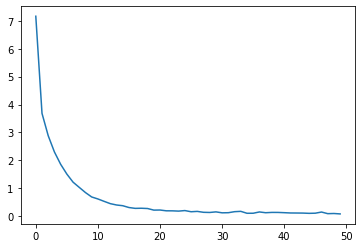

In [13]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(loss_list))), loss_list)

**Inference**

In [14]:
model.eval()
with torch.no_grad():
    inputs = [prepare_sequence(training_data[0][0], word_to_ix)]
    tag_scores = model(inputs)[0]
    tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]
    
    for i, y in zip(training_data[0][0], tags):
        print(i, y)

also O
, O
i O
have O
recently O
discovered O
advil B-Object
liquigels O
work O
much O
better B-Predicate
and O
faster B-Predicate
for O
a O
headache B-Aspect
than O
regular O
ibuprofen B-Object
. O


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [15]:
with open("out_dev.tsv", "w") as w:
    with torch.no_grad():
        for sentence in tqdm(test_data):
            inputs = [prepare_sequence(sentence[0], word_to_ix)]
            tag_scores = model(inputs)[0]
            tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]
            for i, y in zip(sentence[0], tags):
                w.write(f"{i}\t{y}\n")
            w.write("\n")

100%|███████████████████████████████████████████████████████████████████████████████| 283/283 [00:02<00:00, 118.14it/s]


In [16]:
!zip out.zip out_test.tsv

"zip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [17]:
from evaluate_f1_partial import main

In [18]:
main('dev.tsv', 'out_dev.tsv', 'qwerty')